In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Définition de l'architecture U-Net
def unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

def resize_data(images, labels, target_size=(256, 256)):
    resized_images = []
    resized_labels = []
    
    for image, label in zip(images, labels):
        # Convert image to grayscale if it has 3 channels
        if image.shape[-1] == 3:
            image = tf.image.rgb_to_grayscale(image)
        
        # Resize images and labels
        resized_image = tf.image.resize(image, target_size)
        resized_label = tf.image.resize(label, target_size)
        
        resized_images.append(resized_image)
        resized_labels.append(resized_label)
    
    return np.array(resized_images), np.array(resized_labels)

# Chargement des données
def load_data(data_dir):
    image_dir = os.path.join(data_dir, 'image')
    label_dir = os.path.join(data_dir, 'label')

    images = []
    labels = []

    for img_name in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, img_name), color_mode='rgb')
        img_array = img_to_array(img)
        images.append(img_array)

        label = load_img(os.path.join(label_dir, img_name), color_mode='grayscale')
        label_array = img_to_array(label)
        labels.append(label_array)

    return np.array(images), np.array(labels)

# Chargement des données
data_dir = "TB1\\"
images, labels = load_data(data_dir)

# Normalisation des images et étiquettes
images = images / 255.0
labels = labels / 255.0

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Redimensionner les données
# si on veux tester le model avec les vrai dimentions on n'a qu'a preciser dans le parametre de resize_data(512,512)
# et aussi dans les parametres du model: unet(512,512,1)
X_train_resized, y_train_resized = resize_data(X_train, y_train,(128,128))
X_test_resized, y_test_resized = resize_data(X_test, y_test,(128,128))

# Création du modèle U-Net

#change here to 
model = unet((128,128,1))

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement du modèle
#test and change epochs value for quick results small values
model.fit(X_train_resized, y_train_resized, batch_size=8, epochs=20, validation_split=0.1)

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test_resized, y_test_resized)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8063 - loss: 0.5864 - val_accuracy: 0.9021 - val_loss: 0.4103
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8976 - loss: 0.2882 - val_accuracy: 0.9347 - val_loss: 0.1804
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9401 - loss: 0.1352 - val_accuracy: 0.9297 - val_loss: 0.1491
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9448 - loss: 0.1096 - val_accuracy: 0.9188 - val_loss: 0.1753
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9461 - loss: 0.1047 - val_accuracy: 0.9249 - val_loss: 0.1603
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9484 - loss: 0.0988 - val_accuracy: 0.9324 - val_loss: 0.1418
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9502 - loss: 0.0922 - val_accuracy: 0.9413 - val_loss: 0.1203
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9515 - loss: 0.0894 - val_accuracy: 0.9457 - val_loss:

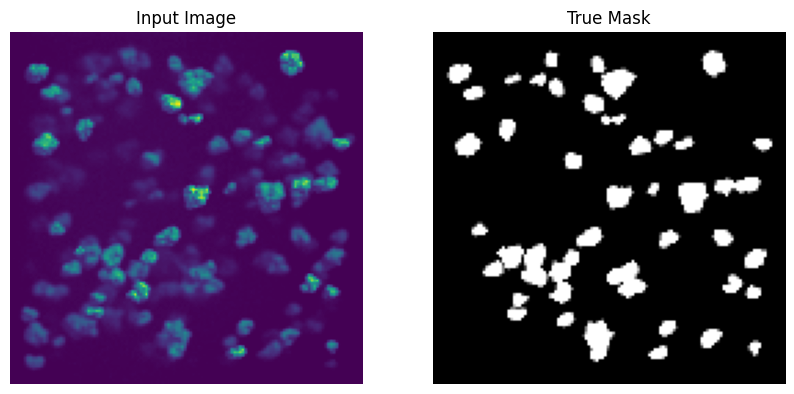

In [3]:
import matplotlib.pyplot as plt

# Define the display function Just so we can visualize before the training what the processed database looks like
def display_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')
    
    plt.show()

# Visualize a random sample image and mask from the training dataset
# just to check the Sample image and sample mask after being resized 
random_index = np.random.choice(X_train_resized.shape[0])  # Choose a random index
sample_image, sample_mask = X_train_resized[random_index], y_train_resized[random_index]
display_image_and_mask(sample_image, sample_mask)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


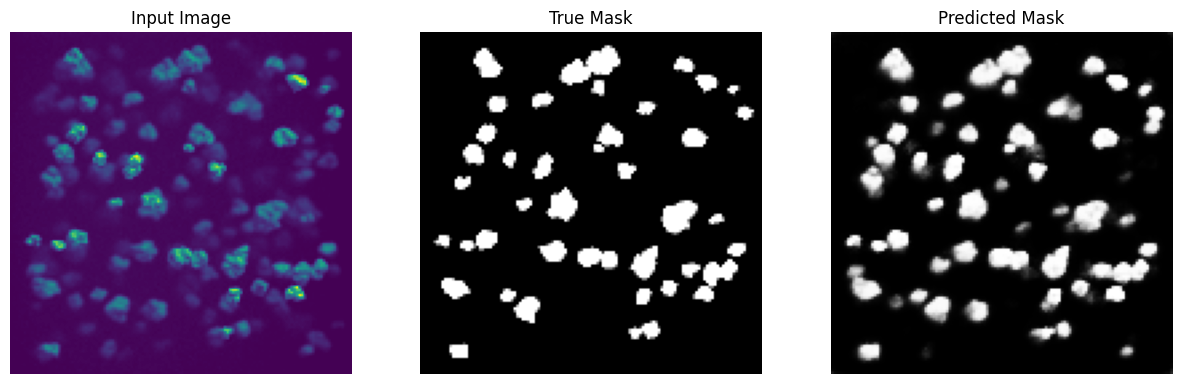

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


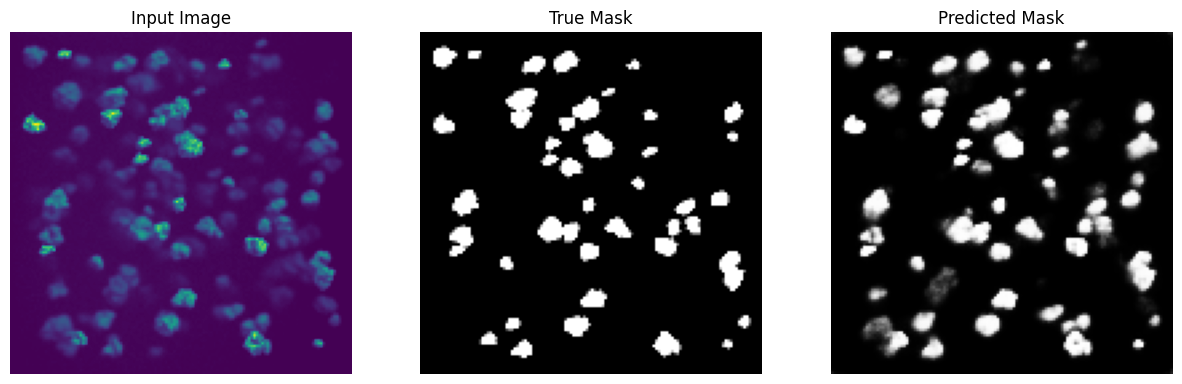

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


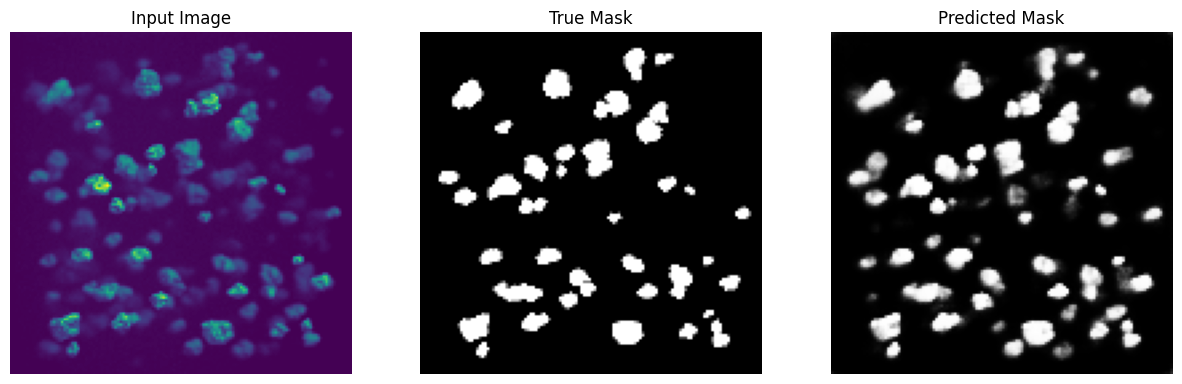

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


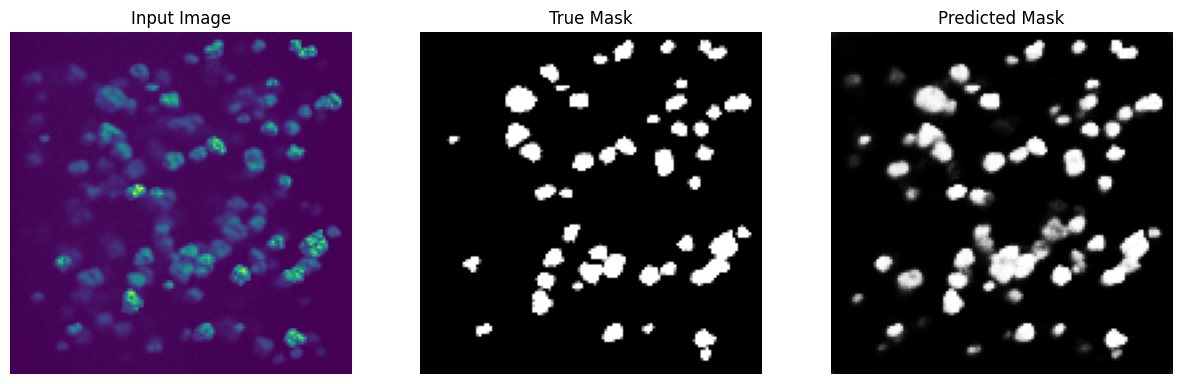

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


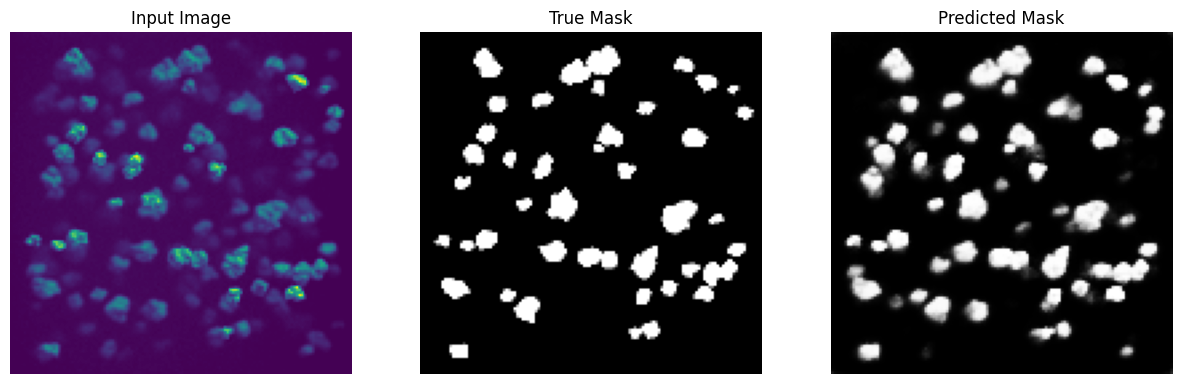

Number of batches: 40


In [6]:
from tensorflow.keras.preprocessing.image import array_to_img

def show_predictions(model, dataset, num=1):
    for i in range(num):
        # Select a random index from the dataset
        random_index = np.random.choice(dataset[0].shape[0])
        sample_image, sample_mask = dataset[0][random_index], dataset[1][random_index]
        
        # Predict mask using the model
        pred_mask = model.predict(sample_image[tf.newaxis, ...])

        # Reshape the predicted mask for visualization
        pred_mask = np.squeeze(pred_mask, axis=0)  # Remove the batch dimension
        pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove the channel dimension if it's grayscale
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(sample_image)
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(sample_mask, cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()
        


# Show predictions on a sample from the test dataset
show_predictions(model, (X_test_resized, y_test_resized), num=5)

# Determine the number of batches in the test dataset
count = 0
for _ in X_test_resized:
    count += 1
print("Number of batches:", count)



In [2]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#a test function used at the beginning to understand and check the size of the available pictures to be treated.
def check_image_sizes(data_dir):
    image_dir = os.path.join(data_dir, 'image')
    label_dir = os.path.join(data_dir, 'label')
    print("Checking image sizes...")
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, img_name)
        if not os.path.exists(label_path):
            print(f"Label for {img_name} not found.")
            continue
        img = load_img(img_path, color_mode='rgb')
        label = load_img(label_path, color_mode='grayscale')
        img_array = img_to_array(img)
        label_array = img_to_array(label)
        print(f"Image: {img_name}")
        print(f" - Image shape: {img_array.shape}")
        print(f" - Label shape: {label_array.shape}")
        # Optional: Break after checking a few images
        # if i >= 10:
        #     break

# Directory containing images and labels
data_dir = "TB1\\"
check_image_sizes(data_dir)


Checking image sizes...
Image: 0.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 1.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 10.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 100.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 101.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 102.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 103.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 104.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 105.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 106.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 107.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 108.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image: 109.png
 - Image shape: (512, 512, 3)
 - Label shape: (512, 512, 1)
Image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


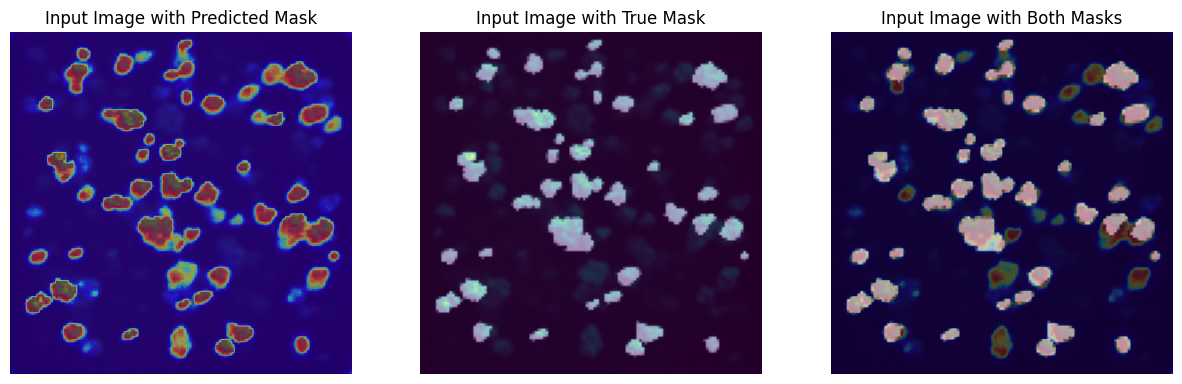

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


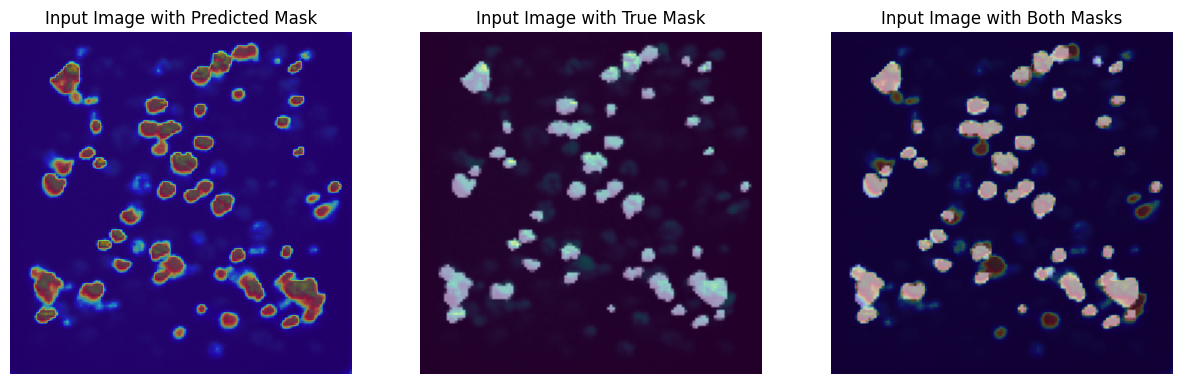

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


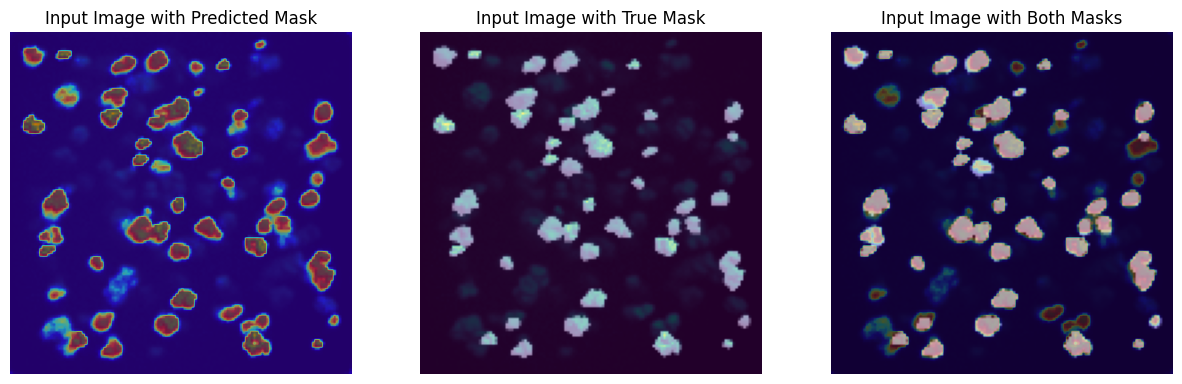

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


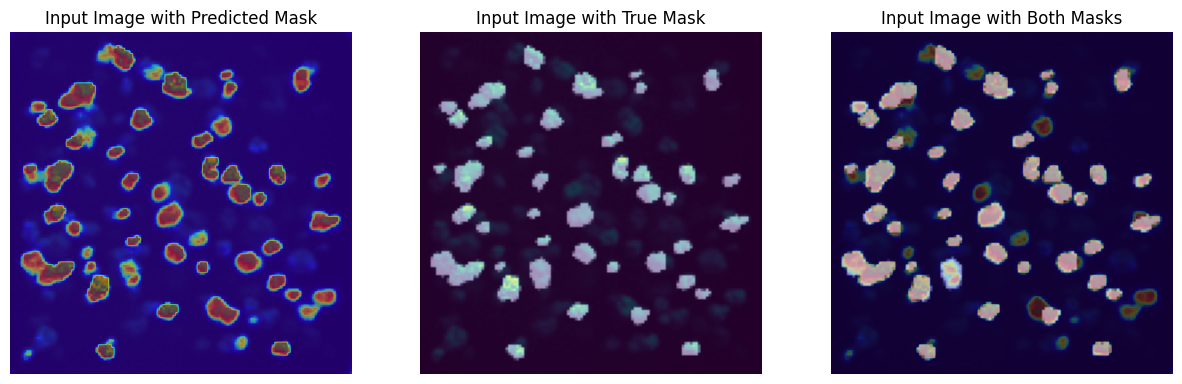

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


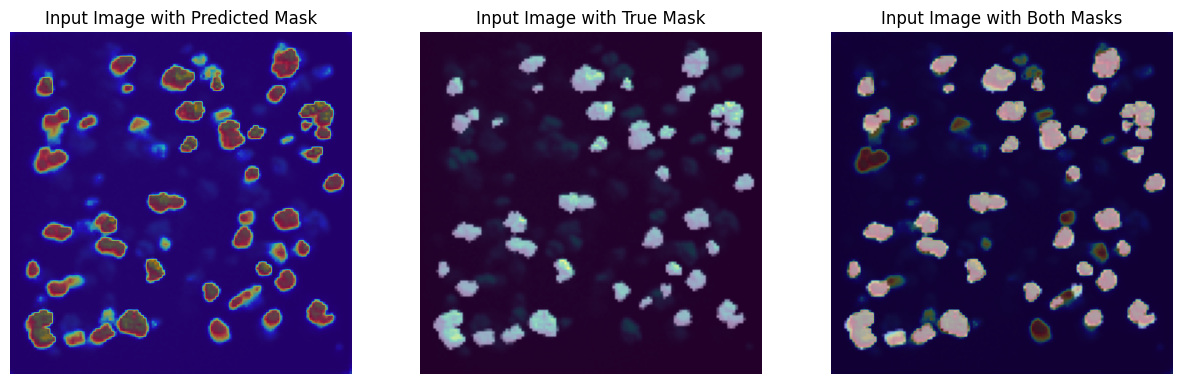

Number of batches: 40


In [7]:
from tensorflow.keras.preprocessing.image import array_to_img

def show_predictions(model, dataset, num=1):
    """this function helps in the visualization of the 
    resulting predicted mask. we superpose the predicted mask with 
    the input image. the input image with the true mask. and finally the input image with both masks."""
    for i in range(num):
        # Selecting a random index from the dataset
        random_index = np.random.choice(dataset[0].shape[0])
        sample_image, sample_mask = dataset[0][random_index], dataset[1][random_index]
        # Predict mask using the model
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        # Reshape the predicted mask for visualization
        pred_mask = np.squeeze(pred_mask, axis=0)  # Remove the batch dimension
        pred_mask = np.squeeze(pred_mask, axis=-1)  # Remove the channel dimension if it's grayscale
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(sample_image)
        plt.imshow(pred_mask, cmap='jet', alpha=0.5)  # Superpose predicted mask onto the input image
        plt.title('Input Image with Predicted Mask')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(sample_image)
        plt.imshow(sample_mask, cmap='gray', alpha=0.5)  # Superpose true mask onto the input image
        plt.title('Input Image with True Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(sample_image)
        plt.imshow(pred_mask, cmap='jet', alpha=0.5)  # Superpose predicted mask onto the input image
        plt.imshow(sample_mask, cmap='gray', alpha=0.5)  # Superpose true mask onto the input image
        plt.title('Input Image with Both Masks')
        plt.axis('off')
        plt.show()

# Show predictions on a sample from the test dataset
show_predictions(model, (X_test_resized, y_test_resized), num=5)

# Determine the number of batches in the test dataset
count = 0
for _ in X_test_resized:
    count += 1
print("Number of batches:", count)
